In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random

load data

In [2]:
def insertGambar(folder):
    images = [] 
    filenames = [] 
    labels = [] 

    for label in os.listdir(folder): 
        for filename in os.listdir("dataset/"+label): 
            img = cv.imread(os.path.join("dataset/"+label,filename), 255) 
            filenames.append(filename) 
            labels.append(label) 
            if img is not None: 
                images.append(img) 
    return images, filenames, labels 

images, filenames, labels = insertGambar("dataset")

resize

In [3]:
def resize_image(image_list, scale_percent):
    resized_images = []
    for img in image_list:
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        resized = cv.resize(img, dim, interpolation=cv.INTER_AREA)
        resized_images.append(resized)
    return resized_images

In [4]:
scaled_percent = 150
resized_images = resize_image(images, scaled_percent)

menampilkan gambar yg sudah di resize

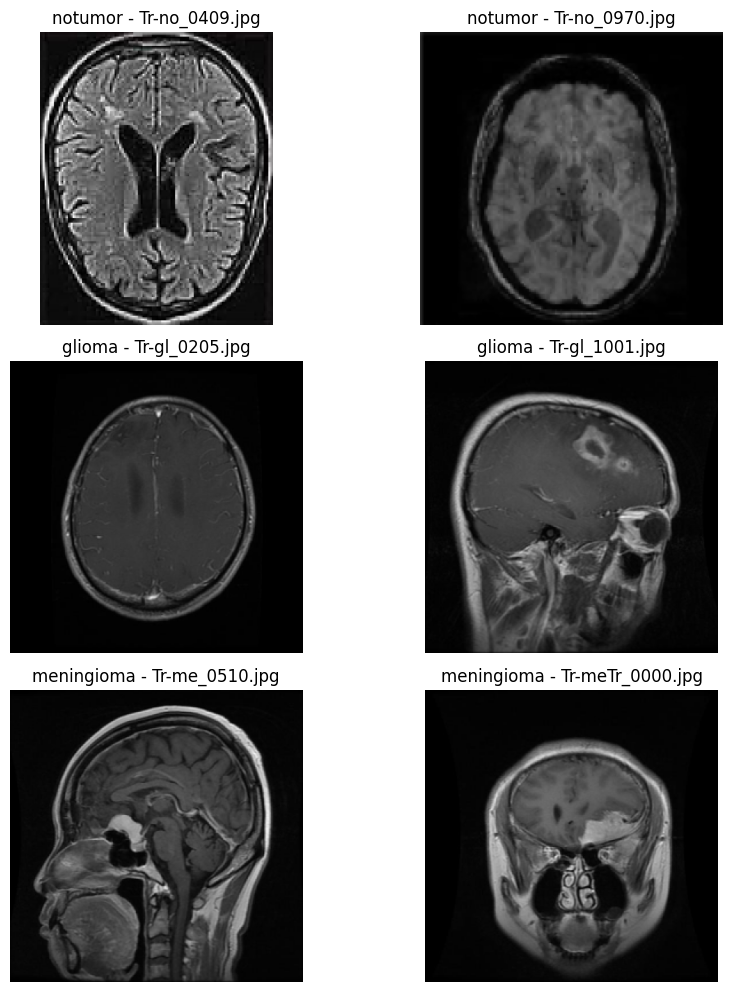

In [5]:
labels_to_display = ['notumor', 'glioma', 'meningioma']
max_images_per_label = 2

fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

for row, label in enumerate(labels_to_display):

    filtered_images = [(img, filename) for img, filename, img_label in zip(resized_images, filenames, labels) if img_label == label]
    
    random.shuffle(filtered_images)
    
    for col in range(min(max_images_per_label, len(filtered_images))):
        img, filename = filtered_images[col]
        ax = axes[row, col]
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax.set_title(f"{label} - {filename}")
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()

augmentasi

rotasi

In [6]:
def rotasi(derajat, citra):
    if len(citra.shape) == 2:
        citra = cv.cvtColor(citra, cv.COLOR_GRAY2RGB)

    panjang, lebar, _ = citra.shape 
    Rotasi_img = np.zeros(citra.shape, dtype=citra.dtype)

    sudut = derajat * (np.pi / 180)
    tengahx = panjang / 2
    tengahy = lebar / 2

    for i in range(panjang):
        for j in range(lebar):
            x = int((i - tengahx) * np.cos(sudut) - (j - tengahy) * np.sin(sudut) + tengahx)
            y = int((i - tengahx) * np.sin(sudut) + (j - tengahy) * np.cos(sudut) + tengahy)
            if 0 <= x < panjang and 0 <= y < lebar:
                Rotasi_img[i][j] = citra[x][y]

    return Rotasi_img

In [7]:
labels_to_display = ['notumor', 'glioma', 'meningioma']
sudut_rotasi = [90, 125, 180, 270]

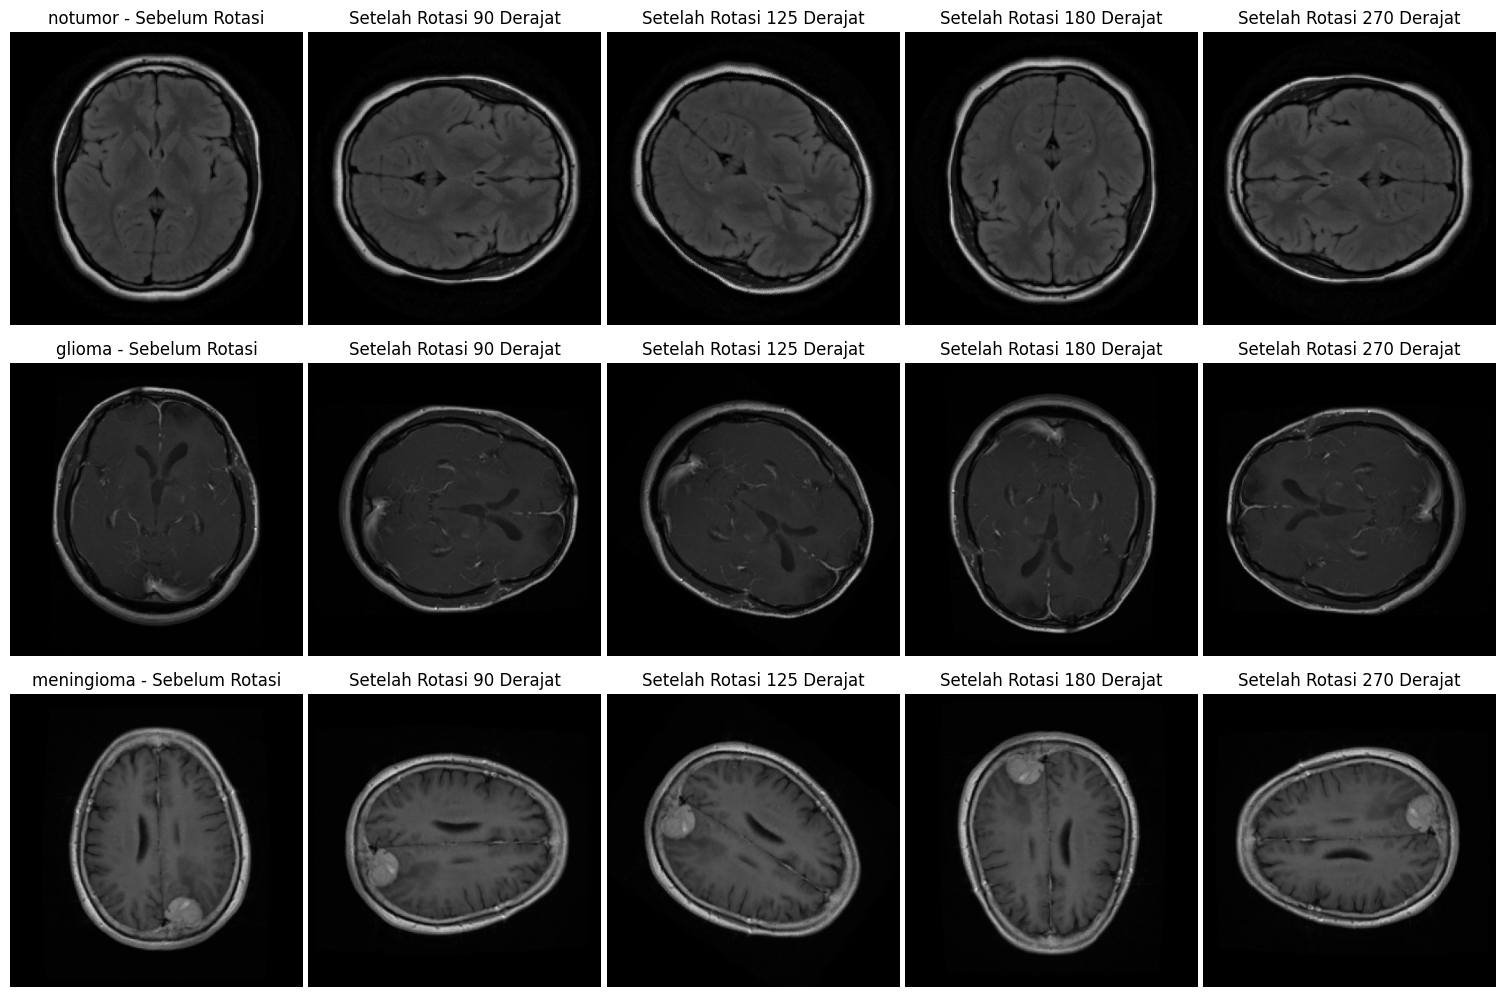

In [8]:
fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=len(sudut_rotasi) + 1, figsize=(15, 10))

for row, label in enumerate(labels_to_display):

    filtered_images = [(img, filename) for img, filename, img_label in zip(resized_images, filenames, labels) if img_label == label]
    random.shuffle(filtered_images)
    citra, filename = filtered_images[0]
    
    if citra.shape[-1] == 1:
        citra = cv.cvtColor(citra, cv.COLOR_GRAY2RGB)

    ax = axes[row, 0]
    ax.imshow(cv.cvtColor(citra, cv.COLOR_BGR2RGB))
    ax.set_title(f'{label} - Sebelum Rotasi')
    ax.axis('off')
    
    for col, sudut in enumerate(sudut_rotasi):
        rotated_image = rotasi(sudut, citra)
        rotated_image = np.clip(rotated_image, 0, 255).astype(np.uint8) 
        ax = axes[row, col+1]
        ax.imshow(cv.cvtColor(rotated_image, cv.COLOR_BGR2RGB))
        ax.set_title(f'Setelah Rotasi {sudut} Derajat')
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=0.5)
plt.show()

thresholding

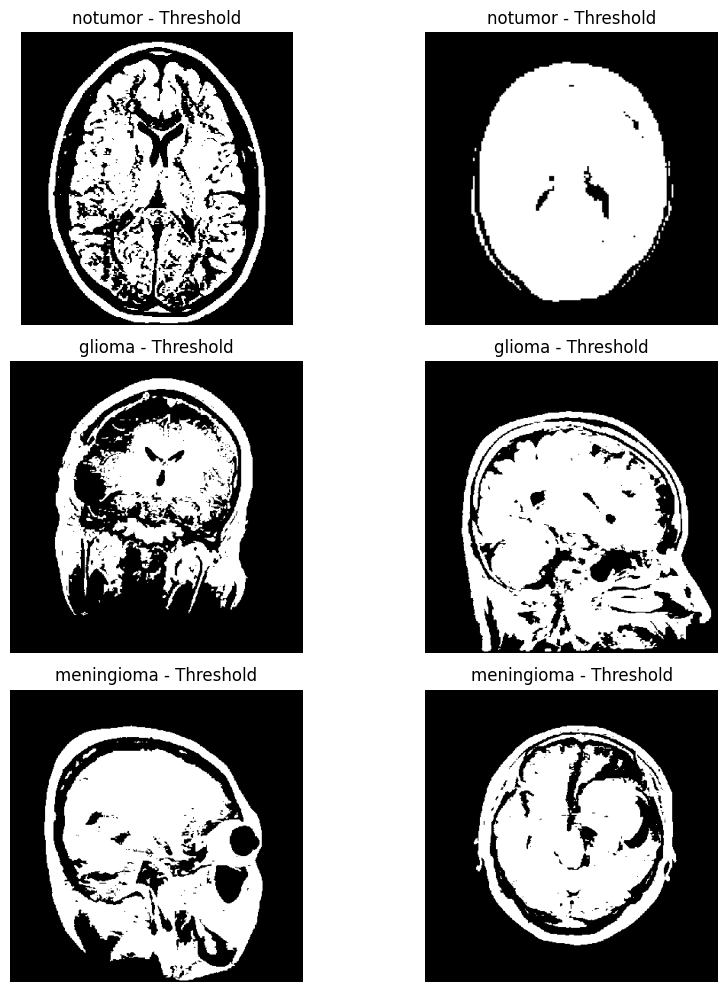

In [9]:
def apply_threshold(image_list):
    thresholded_images = []
    for img in image_list:
        if len(img.shape) == 3 and img.shape[-1] == 3:
            gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            gray_img = img
        _, thresholded_img = cv.threshold(gray_img, 60, 255, cv.THRESH_BINARY)
        thresholded_images.append(thresholded_img)
    return thresholded_images

sampled_images = []
sampled_labels = []
for label in labels_to_display:
    filtered_images = [img for img, img_label in zip(resized_images, labels) if img_label == label]
    sampled = random.sample(filtered_images, min(max_images_per_label, len(filtered_images)))
    sampled_images.extend(sampled)
    sampled_labels.extend([label] * len(sampled))

thresholded_images = apply_threshold(sampled_images)

fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

for row, label in enumerate(labels_to_display):
    filtered_images = [(img, filename) for img, filename, img_label in zip(thresholded_images, sampled_labels, sampled_labels) if img_label == label]
    
    for col in range(min(max_images_per_label, len(filtered_images))):
        img, filename = filtered_images[col]
        ax = axes[row, col]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{label} - Threshold")
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()

deteksi tepi canny

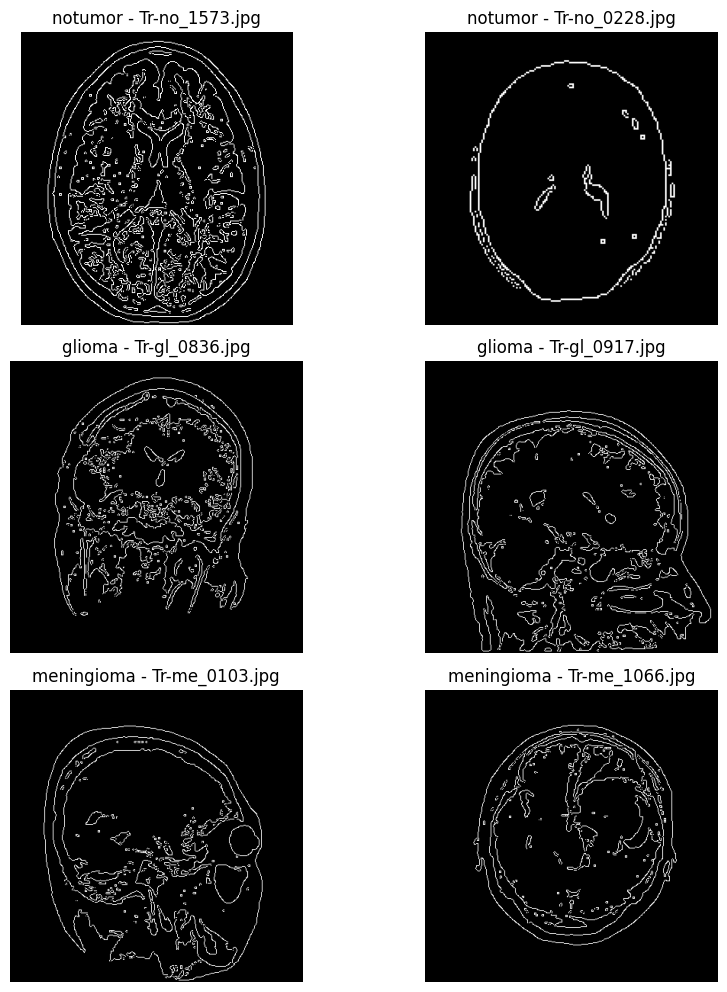

In [10]:
edge_detected_images = []
lower_bound = 100
upper_bound = 200

for img in thresholded_images:
    edge_detected_img = cv.Canny(img, lower_bound, upper_bound)
    edge_detected_images.append(edge_detected_img)

fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

index = 0
for row, label in enumerate(labels_to_display):
    filtered_filenames = [filename for filename, img_label in zip(filenames, labels) if img_label == label]
    random.shuffle(filtered_filenames)
    for col in range(max_images_per_label):
        if index < len(edge_detected_images):
            ax = axes[row, col]
            ax.imshow(edge_detected_images[index], cmap='gray')
            ax.set_title(f"{label} - {filtered_filenames[index % len(filtered_filenames)]}")
            ax.axis('off')
            index += 1

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()

segmentasi

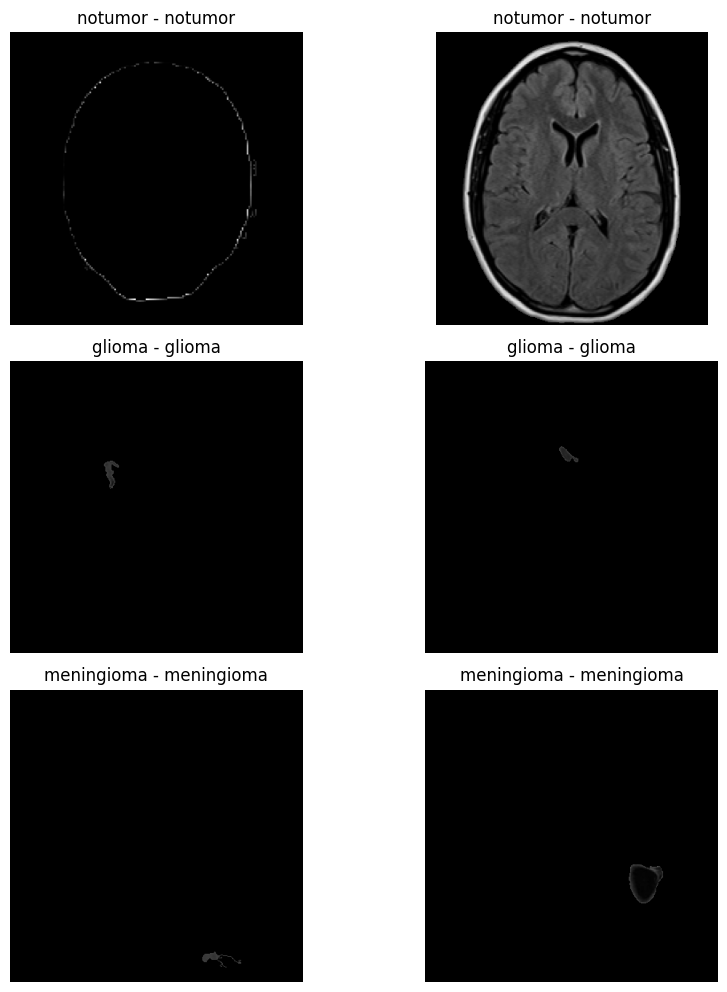

In [11]:
contour_masks = []  
segmented_images = []  

original_indices = list(range(len(sampled_images)))
random.shuffle(original_indices)

for idx in original_indices:
    edge_img = edge_detected_images[idx]
    contours = cv.findContours(edge_img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[-2]
    if contours:
        largest_contour = sorted(contours, key=cv.contourArea, reverse=True)[0]
        contour_mask = np.zeros(edge_img.shape[:2], dtype='uint8')
        cv.drawContours(contour_mask, [largest_contour], -1, 255, -1)
        contour_masks.append(contour_mask)

        combined_image = cv.bitwise_and(sampled_images[idx], sampled_images[idx], mask=contour_mask)
        segmented_images.append(cv.cvtColor(combined_image, cv.COLOR_BGR2RGB))

fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

index = 0
for row, label in enumerate(labels_to_display):
    for col in range(max_images_per_label):
        if index < len(segmented_images):
            ax = axes[row, col]
            ax.imshow(segmented_images[index])
            ax.set_title(f"{label} - {sampled_labels[index]}")
            ax.axis('off')
            index += 1

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()

deteksi tepi 

In [12]:
def sobel_edge_detection(image):
    # If image is already grayscale, ensure it's in uint8 format
    if len(image.shape) == 3 and image.shape[-1] == 3:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        gray = image.astype(np.uint8)
    else:
        raise ValueError("Unsupported image format. Expected BGR or grayscale image.")

    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    rows, cols = gray.shape
    edges = np.zeros((rows, cols), dtype=np.uint8)

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            gx = np.sum(Gx * gray[i-1:i+2, j-1:j+2])
            gy = np.sum(Gy * gray[i-1:i+2, j-1:j+2])
            magnitude = np.sqrt(gx**2 + gy**2)
            edges[i, j] = min(255, int(magnitude))

    return edges


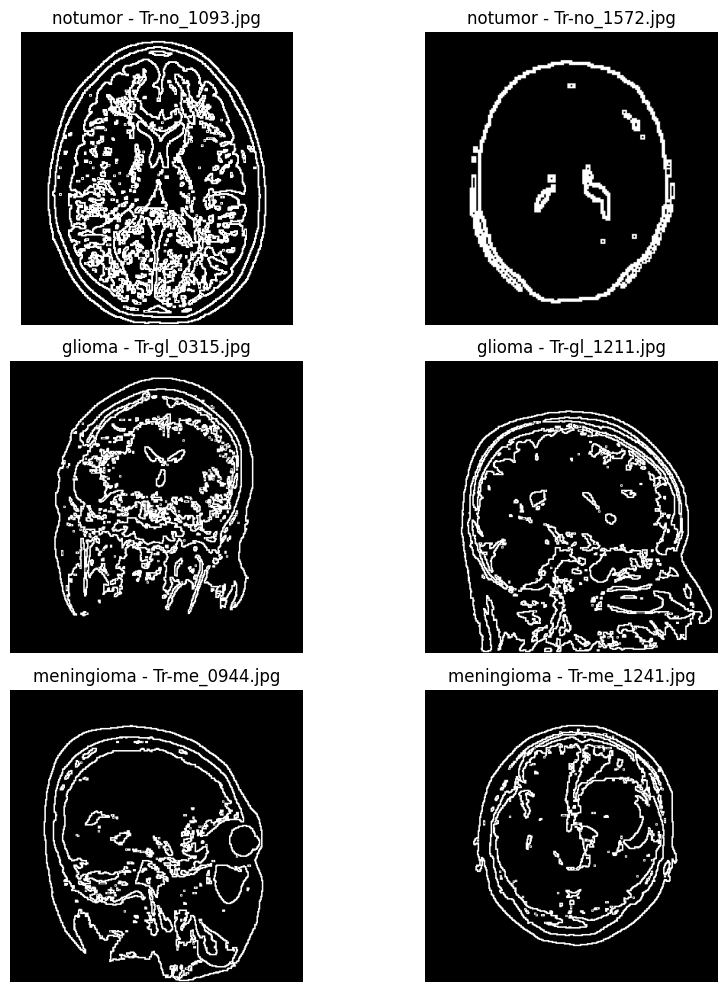

In [15]:
# Apply edge detection (Sobel)
edge_detected_images = []
for img in thresholded_images:
    edge_detected_img = sobel_edge_detection(img)
    edge_detected_images.append(edge_detected_img)

# Display edge detected images
fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

index = 0
for row, label in enumerate(labels_to_display):
    filtered_filenames = [filename for filename, img_label in zip(filenames, labels) if img_label == label]
    random.shuffle(filtered_filenames)
    for col in range(max_images_per_label):
        if index < len(edge_detected_images):
            ax = axes[row, col]
            ax.imshow(edge_detected_images[index], cmap='gray')
            ax.set_title(f"{label} - {filtered_filenames[index % len(filtered_filenames)]}")
            ax.axis('off')
            index += 1

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()
